<a href="https://colab.research.google.com/github/Maks3174/Phy/blob/main/notebookc2ea259ad2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leukemia-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F849724%2F1449674%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240808%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240808T161433Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8801894f4cf4edef841c411b30398268a50bc097b3ebeb813bd8cacd690c0d373bb3fbfad86da249aa3345db65f872a9c55c00971586e726a8528dd5cbf1a51f12a97c7cd5b7b8509df82bb3124c2c22a21a7c29f3f935563e5da9af45c5a06d89c06841978448ccf63c46b4f252a8c625b71a4f2eb9f7c5f6406bd56e32458a346332fd9111108b733b6a790de5a60bbb7b22dda22cd57e6abff48583a85018aae86958a52a1776d0886e60ae11581c365939a4590730e9439d797b64d8b82682305a2a89335095c42d43481ac096205e0fd42ba3d279c6e89b9dec4f53a97195b45eb9744377abb1c67379cc71c52f67a11d2ab5a2db96137251c8d34ee554'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
data_dir1 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0'
data_dir2 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1'
data_dir3 = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2'

# Створіть екземпляр ImageFolder
dataset1 = datasets.ImageFolder(root=data_dir1)
dataset2 = datasets.ImageFolder(root=data_dir2)
dataset3 = datasets.ImageFolder(root=data_dir3)

In [ ]:
from torch.utils.data import ConcatDataset

dataset = ConcatDataset([dataset1, dataset2, dataset3])

print(len(dataset))

dataset[0]

10661


(<PIL.Image.Image image mode=RGB size=450x450>, 0)

In [ ]:
dataset1.classes

['all', 'hem']

In [ ]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [ ]:
len(train_data), len(val_data)

(8529, 2132)

In [ ]:
train_data[0]

(<PIL.Image.Image image mode=RGB size=450x450>, 0)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [ ]:
batch_size = 512

# Створіть завантажувачі даних
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

In [ ]:
len(train_data), len(val_data)

(8529, 2132)

In [ ]:
import os
from PIL import Image


class ImageDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for loading and preprocessing images.
    """
    def __init__(self, root_dir, transform=None):
        """
        Args:
          root_dir (str): Path to the directory containing images.
          transform (torchvision.transforms, optional): Transformations to apply to images. Defaults to None.
        """
        self.root_dir = root_dir

        self.classes = os.listdir(root_dir)
        categories = os.listdir(os.path.join(root_dir, self.classes[0]))

        self.class_to_idx = {x[1]: x[0] for x in enumerate(categories)}

        print(self.class_to_idx)

        self.image_paths = self.get_pathes(root_dir)

        self.transform = transform

    def get_pathes(self, root):
        image_paths = []
        folders = os.listdir(root)

        for folder in folders:
            file_list_all = os.listdir(os.path.join(root, folder, list(self.class_to_idx.keys())[0]))
            for file in file_list_all:
                image_paths.append(os.path.join(root, folder, list(self.class_to_idx.keys())[0], file))

            file_list_hem = os.listdir(os.path.join(root, folder, list(self.class_to_idx.keys())[1]))
            for file in file_list_hem:
                image_paths.append(os.path.join(root, folder, list(self.class_to_idx.keys())[1], file))

        return image_paths

    def __len__(self):
        """
        Returns the number of images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Loads and preprocesses an image at a given index.

        Args:
          idx (int): Index of the image to return.

        Returns:
          tuple: A tuple containing the preprocessed image and its label (if available).
        """
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Assuming RGB images
        if self.transform:
            image = self.transform(image)

        # Add logic to load labels if available (modify based on your data structure)
        print(os.path.normpath(image_path).split(os.path.sep))
        label_name = os.path.normpath(image_path).split(os.path.sep)[-2]

        return image, self.class_to_idx[label_name]

In [ ]:
data_dir='/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data'

In [ ]:
os.listdir(data_dir)

['fold_0', 'fold_1', 'fold_2']

In [ ]:
custom_train_data = ImageDataset(data_dir)
custom_test_data = ImageDataset(data_dir)


{'all': 0, 'hem': 1}
{'all': 0, 'hem': 1}


In [ ]:
print(custom_train_data[0])

['', 'kaggle', 'input', 'leukemia-classification', 'C-NMC_Leukemia', 'training_data', 'fold_0', 'all', 'UID_28_5_3_all.bmp']
(<PIL.Image.Image image mode=RGB size=450x450 at 0x7D93EB3CB970>, 0)


In [ ]:
len(custom_train_data), len(custom_test_data)

(10661, 10661)

['', 'kaggle', 'input', 'leukemia-classification', 'C-NMC_Leukemia', 'training_data', 'fold_0', 'all', 'UID_28_5_3_all.bmp']


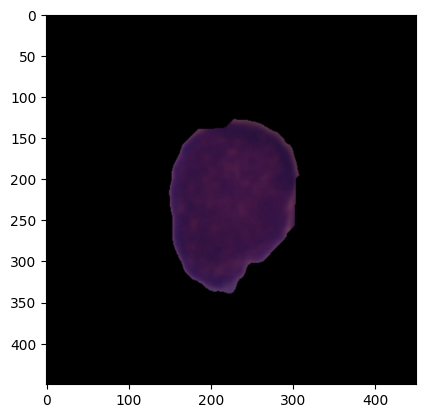

['', 'kaggle', 'input', 'leukemia-classification', 'C-NMC_Leukemia', 'training_data', 'fold_0', 'all', 'UID_45_24_5_all.bmp']


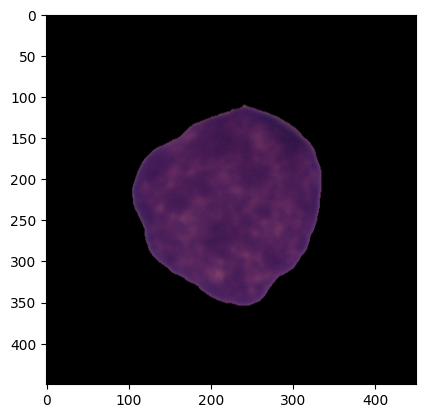

['', 'kaggle', 'input', 'leukemia-classification', 'C-NMC_Leukemia', 'training_data', 'fold_0', 'all', 'UID_45_7_1_all.bmp']


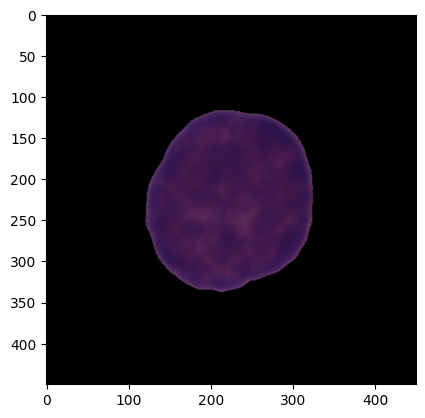

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(3):  # Show 3 images
    img, label = custom_train_data[i]

    # Get the image data (tensor) and convert it back to a NumPy array for manipulation
    img = np.asarray(img)

    # Convert the color channels from (channels, height, width) to (height, width, channels) for pyplot
#     img = img.transpose((1, 2, 0))

    # Get the label name from the dataset class labels
#     label_name = dataset.classes[label]

    # Plot the image with a title (including label name)
    plt.imshow(img)
#     plt.title(f"Image: {i+1}, Label: {label_name}")
    plt.show()

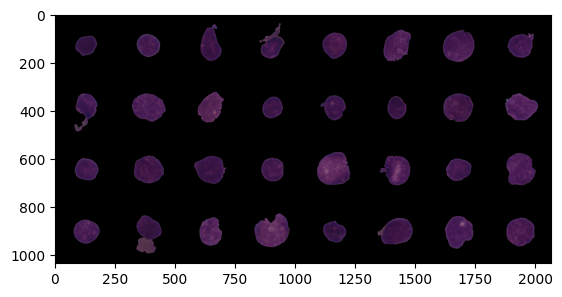

In [ ]:
from torchvision.utils import make_grid

loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0) # результатом є тензор

plt.imshow(grid)

In [ ]:
batch.shape

torch.Size([32, 3, 256, 256])

In [ ]:
import numpy as np
from torch import nn
import torch.nn.functional as F


class FractureClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(32*6*6, 256)
        self.linear2 = nn.Linear(256, num_classes)


    def forward(self, x):
        # x - (batch, 1, 256, 256)
        out = self.conv1(x) # (batch, 8, 254, 254)
        out = F.relu(out)

        out = self.conv2(out) # (batch, 16, 252, 252)
        out = F.relu(out)

        out = self.pool1(out) # (batch, 16, 126, 126)

        out = self.conv3(out) # (batch, 32, 124, 124)
        out = F.relu(out)

        out = self.pool2(out) # (batch, 32, 62, 62)

        out = self.conv4(out) # (batch, 32, 60, 60)
        out = F.relu(out)

        out = self.pool3(out) # (batch, 32, 30, 30)

        out = self.conv5(out) # (batch, 32, 28, 28)
        out = F.relu(out)

        out = self.pool4(out) # (batch, 32, 14, 14)

        out = self.conv6(out) # (batch, 32, 12, 12)
        out = F.relu(out)

        out = self.pool5(out) # (batch, 32, 6, 6)

        out = self.flatten(out) # (batch, 32*6*6)

        out = self.linear1(out)
        out = F.relu(out)

        out = self.linear2(out)
        #out = F.softmax(out, dim=-1)
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = FractureClassifier(2).to(device)
model

FractureClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
!pip install -q torchsummary

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ERROR: Could not find a version that satisfies the requirement torchsummary (from versions: none)
ERROR: No matching distribution found for torchsummary


In [ ]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
# Визначення функції втрат та оптимізатора

loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):
        print('Epoch`s num:', epoch  + 1)
        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

In [ ]:
plot_metric(history, 'accuracy_score')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset1.classes)
plt.xticks(rotation=90)
plt.plot()